In [21]:
from ultis import *
import neal
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
import pyqubo as pyq
from dwave.system import LeapHybridSampler, DWaveSampler, EmbeddingComposite
import dwave.inspector
import matplotlib.pyplot as plt
%matplotlib widget

### Create functions to define quadratic model and convert to qubo

In [22]:
def define_variables(costs, model):
    var = set()
    for ijk in costs.keys():
        i, j, k = ijk[0], ijk[1], ijk[2]
        var.add((i, j))
        var.add((j, k))
    var = sorted(var, key=lambda x: (x[0], x[1]))
    x = model.binary_var_dict(var, name='x')
    return x


In [23]:
def create_constrained_quadratic_model(costs, hits, hits_by_layers, alpha):
    NL = len(hits_by_layers.keys())
    print("Number of layers: ", NL)
    hit_last_layer = hits_by_layers[NL - 1]
    NhitS = len(hits) - len(hit_last_layer)
    print("Number of hits, without last layer: ", NhitS)

    model = Model(name="Track finding")
    model.float_precision = 8
    x = define_variables(costs, model)
    ob_funct = model.sum(-w * alpha * x[(ijk[0], ijk[1])] * x[(ijk[1], ijk[2])] for ijk, w in costs.items())
    model.minimize(ob_funct)
    for h in hits:
        k = h.index
        constraint_out = []
        constraint_in = []
        for k_1 in x.keys():
            if ((h.layer_id < (NL - 1)) and (k_1[0] == k)):
                constraint_out.append(x[(k_1[0], k_1[1])])
            if ((h.layer_id > 0) and (k_1[1] == k)):
                constraint_in.append(x[(k_1[0], k_1[1])])
        if (len(constraint_out) > 0):
            model.add_constraint(model.sum(constraint_out) == 1)
        if (len(constraint_in) > 0):
            model.add_constraint(model.sum(constraint_in) == 1)
    return model


In [24]:
def convert_to_qubo(model, gamma, path):
    quadratic_program = from_docplex_mp(model)
    qubo = QuadraticProgramToQubo(penalty=gamma).convert(quadratic_program)
    num_vars = qubo.get_num_binary_vars()
    print(
        f"To represent the inital problem with {model.number_of_binary_variables} variables, the QUBO representation needs {num_vars} variables")

    qubo.write_to_lp_file(path)

    const = qubo.objective.constant

    model_const = pyq.Num(const)

    xq = {}
    i = 0
    for var in qubo.variables:
        xq[i] = pyq.Binary(var.name)
        i += 1
    model_lin = sum((coef * xq[idx]) for idx, coef in qubo.objective.linear.to_dict().items())

    model_quad = sum(coef * xq[i] * xq[j] for (i, j), coef in qubo.objective.quadratic.to_dict().items())

    model_full = model_lin + model_quad + model_const
    return model_full.compile()


In [25]:
def create_hamiltonian(costs, hits, hits_by_layers, alpha, gamma, path):
    model = create_constrained_quadratic_model(costs, hits, hits_by_layers, alpha)
    model = convert_to_qubo(model, gamma, path)
    return model

### Create function to Dwave solver

In [26]:
def dwave_solver(H):
    sampler = LeapHybridSampler()
    bqm = H.to_bqm()
    start = time.time()
    response = sampler.sample(bqm)
    end = time.time()
    print("Execution time:", end - start)
    ob_value = response.first.energy
    result = response.first.sample
    return ob_value, result

### Display result

In [27]:
def display(list_hits, result, out=""):
    segments = list()
    for k, v in result.items():
        if v == 1:
            if type(k) is str:
                k = [int(e) for e in k.split('_')[1:]]
            h_1 = list_hits[k[0]]
            h_2 = list_hits[k[1]]
            segments.append([h_1, h_2])
    print("No_segments:", len(segments))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = []
    ys = []
    zs = []

    for h in list_hits:
        xs.append(h.x)
        ys.append(h.y)
        zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')

    for segment in segments:
        h1 = segment[0]
        h2 = segment[1]
        ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.savefig(out)
    plt.show()

In [28]:
def run_script(no_tracks, beta_max, m, alpha, gamma):
    src_path = '../../src/data_selected'
    folder = '/'+ str(no_tracks)+'hits/known_track/'
    out_path = 'results'
    data_path = src_path + folder + 'hits.csv'
    figure_path_out = out_path + folder + "result_D_QUBM.PNG"
    check_path(out_path + folder)
    
    # read data
    print("Loading data...")
    start = time.time()
    hits_by_layers, hits = read_hits(data_path)
    end = time.time()
    print("Loaded data! Execution time: ", end - start)

    re_calculate = False
    costs_path_out = out_path + folder + "pi_" + str(A) + "costs.json"
    if os.path.exists(costs_path_out) == False:
        re_calculate = True
    if re_calculate:
        # calculate costs
        print("\n----Compute cost----")
        start = time.time()
        costs = get_costs(hits_by_layers, beta_max)
        end = time.time()
        print('Complete!. Execution time: ', end - start, 's')
    
        print("\n---Write cost out---")
        print("Path: ", costs_path_out)
        write_costs(costs, costs_path_out, m)
    
    # load data
    print("---Load cost---")
    costs = load_costs(costs_path_out)
    print("---Loaded cost---")

    print("\n ----Create Hamiltonian----")
    model_path_out = out_path + folder + "model_D_QUBM.lp"
    H = create_hamiltonian(costs, hits, hits_by_layers, alpha, gamma, model_path_out)
    print("----Created Hamiltonian----")

    print("\n----Dwave Hybird solver----")
    ob_value, result = dwave_solver(H)
    print("Objective value:", ob_value / alpha)
    cal_expected_value(hits, m)
    display(hits, result, out=figure_path_out)

Loading data...
Loaded data! Execution time:  0.035340070724487305
---Load cost---
---Loaded cost---

 ----Create Hamiltonian----
Number of layers:  7
Number of hits, without last layer:  1200
To represent the inital problem with 37021 variables, the QUBO representation needs 37021 variables
----Created Hamiltonian----

----Dwave Hybird solver----
Execution time: 39.71853995323181
Objective value: -3.4674219042965837
Expected cost : -3.4719486020214205
Expected No. segments : 1200
No_segments: 1200


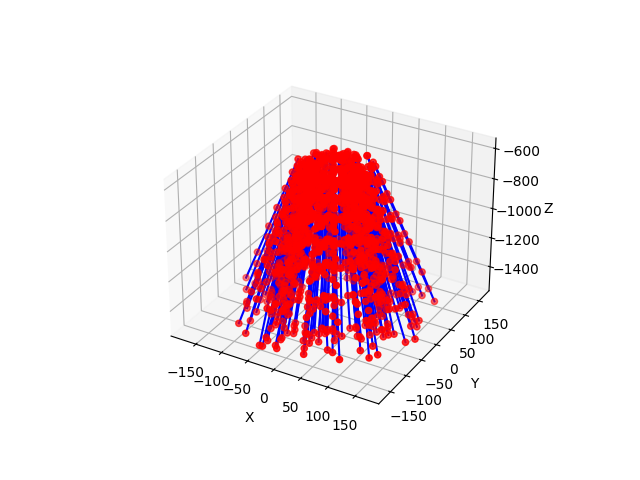

In [29]:
if __name__ == '__main__': # Keep this line if we want to run multiprocessing
    no_tracks = 200
    # weight
    A = 300
    beta_max = math.pi / A
    m = 1
    alpha = 200
    gamma = 1
    run_script(no_tracks, beta_max, m, alpha, gamma)

In [30]:
plt.close()